In [2]:
from glob import glob
from collections import defaultdict
from os.path import basename
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve, auc
from pqdm.processes import pqdm
from scipy.stats import ttest_rel

os.chdir('/home/vladimirnoz/ibis')

HITS_THR = 10

In [3]:
g2a = 'CAMTA1	LEUTX\tMYF6	PRDM13	SALL3	USF3	ZBED2	ZBED5	ZNF20	ZNF251	ZNF367	ZNF395	ZNF493	ZNF518B	ZNF648'
g2a = set(g2a.split('\t'))

In [4]:
g2a

{'CAMTA1',
 'LEUTX',
 'MYF6',
 'PRDM13',
 'SALL3',
 'USF3',
 'ZBED2',
 'ZBED5',
 'ZNF20',
 'ZNF251',
 'ZNF367',
 'ZNF395',
 'ZNF493',
 'ZNF518B',
 'ZNF648'}

In [6]:
paths = glob('aaa_submissions/*/*@*')
pwms = defaultdict(list)
tables_list = []
for file in tqdm(paths):
    title = basename(file).replace('GHTS', 'ghtselex').replace('CHS', 'chipseq').replace('.txt', '')
    team_name = file.split('/')[-2]
    scores = pd.read_table(file, names=['score'])
    snps = pd.read_table(f'fasta/{title}.fasta', names=['name'])['name']
    snps = snps[snps.str.match('>')].str.replace('>', '').str.split('@', expand=True).reset_index().drop('index', axis=1)
    snps.columns = ['#chr', 'end', 'ref', 'alt', 'allele']
    snps['score'] = scores
    asb = pd.read_table(f'asb/{title.replace("ght", "")}.tsv')
    asb['ref_score'] = snps.query('allele == "ref"').reset_index()['score']
    asb['alt_score'] = snps.query('allele == "alt"').reset_index()['score']
    tf = title.split('@')[1]
    asb['tf'] = tf
    asb['exp'] = title.split('@')[0]
    asb['team'] = team_name
    asb['discipline'] = 'G2A' if tf in g2a else 'A2G'
    tables_list.append(asb)
df = pd.concat(tables_list)
df['score'] = df[['ref_score', 'alt_score']].max(axis=1)
df

  0%|          | 0/210 [00:00<?, ?it/s]

,#chr,start,end,mean_bad,id,max_cover,ref,alt,n_reps,bads,...,comb_es,comb_pval,fdr_comb_pval,ref_score,alt_score,tf,exp,team,discipline,score
0,chr1,22260981,22260982,2.0,rs115906406,52,G,T,3,"2,2,2",...,0.384132,0.137527,0.907677,0.055317,0.061762,MYF6,ghtselex,Salimov.and.Frolov.Laboratory,G2A,0.061762
1,chr15,81849640,81849641,2.0,rs2029697,41,C,A,2,"2,2",...,0.001168,0.395083,0.757510,0.945811,0.943306,MYF6,ghtselex,Salimov.and.Frolov.Laboratory,G2A,0.945811
2,chr18,80034409,80034410,2.0,rs9952181,129,C,T,3,"2,2,2",...,1.516696,0.000882,0.043678,0.303657,0.131411,MYF6,ghtselex,Salimov.and.Frolov.Laboratory,G2A,0.303657
3,chr1,3585722,3585723,2.0,rs62653679,38,G,A,2,"2,2",...,-0.038472,0.319223,0.954024,0.034812,0.199766,MYF6,ghtselex,Salimov.and.Frolov.Laboratory,G2A,0.199766
4,chr1,4092145,4092146,2.0,rs4654410,231,C,T,5,"2,2,2,2,2",...,0.244424,0.213200,0.757510,0.183182,0.216282,MYF6,ghtselex,Salimov.and.Frolov.Laboratory,G2A,0.216282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,chr5,81972014,81972015,3.0,rs112181309,56,G,T,1,3,...,1.278773,0.044902,0.239866,0.684992,0.707944,MYPOP,ghtselex,Biology.Impostor,A2G,0.707944
59,chr5,107939012,107939013,3.0,rs79955751,38,C,T,1,3,...,1.171158,0.055948,0.472454,0.579804,0.555051,MYPOP,ghtselex,Biology.Impostor,A2G,0.579804
60,chr12,108562580,108562581,2.0,rs2287554,84,C,T,2,"2,2",...,-0.004261,0.302208,0.791994,0.518816,0.519493,MYPOP,ghtselex,Biology.Impostor,A2G,0.519493
61,chr15,78800407,78800408,2.0,rs7173267,27,G,C,1,2,...,-0.198680,0.373447,0.937103,0.552379,0.578232,MYPOP,ghtselex,Biology.Impostor,A2G,0.578232


In [8]:
np.random.seed(777)

random = df[['#chr', 'start', 'end', 'ref', 'alt', 'comb_pval', 'ref_comb_pval', 'alt_comb_pval', 'discipline', 'tf', 'fdr_comb_pval']].drop_duplicates()
random = random.query('fdr_comb_pval < 0.05')
random['ref_score'] = np.random.rand(len(random))
random['alt_score'] = np.random.rand(len(random))
random

,#chr,start,end,ref,alt,comb_pval,ref_comb_pval,alt_comb_pval,discipline,tf,fdr_comb_pval,ref_score,alt_score
2,chr18,80034409,80034410,C,T,8.823850e-04,9.793029e-01,8.823850e-04,G2A,MYF6,4.367806e-02,0.152664,0.898289
6,chr8,141447226,141447227,G,C,2.403738e-05,2.403738e-05,9.648941e-01,G2A,MYF6,2.379700e-03,0.302357,0.276551
12,chr16,780952,780953,G,A,1.390934e-08,9.952735e-01,1.390934e-08,G2A,MYF6,1.377025e-06,0.062036,0.459858
7,chr17,51435817,51435818,A,G,6.529823e-05,9.699438e-01,6.529823e-05,G2A,USF3,8.986280e-04,0.459860,0.900924
8,chr9,135769032,135769033,A,G,1.364122e-30,1.000000e+00,1.364122e-30,G2A,USF3,3.942313e-28,0.835253,0.115327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,chr16,78326765,78326766,G,A,4.102108e-05,4.102108e-05,9.993658e-01,A2G,MSANTD1,1.742182e-02,0.247561,0.528480
9221,chr17,6653006,6653007,G,A,1.535161e-05,1.535161e-05,9.993374e-01,A2G,MSANTD1,8.028890e-03,0.245845,0.091500
9461,chr20,17964422,17964423,T,G,3.453362e-07,3.453362e-07,9.576057e-01,A2G,MSANTD1,6.582793e-04,0.365600,0.119950
9524,chr20,58654245,58654246,A,C,3.628140e-08,3.628140e-08,9.999992e-01,A2G,MSANTD1,1.266560e-04,0.250145,0.544458


In [9]:
df['team'].unique()

array(['Salimov.and.Frolov.Laboratory', 'mj', 'pwmsandme', 'Medici',
       'Biology.Impostor'], dtype=object)

In [10]:
def get_concordance(row, thr):
     model_ref, model_alt = row['ref_score'], row['alt_score']
     as_ref, as_alt = row['ref_comb_pval'], row['alt_comb_pval']
     hit = max(model_ref, model_alt) > thr
     if not hit:
         return 'No Hit'
     elif (as_alt - as_ref) * (model_ref - model_alt) > 0:
         return 'Concordant'
     else:
          return 'Discordant'

def get_curve(df):
    thresholds = np.linspace(df[['ref_score', 'alt_score']].min().min(), df[['ref_score', 'alt_score']].max().max(), num=100)
    thresholds = sorted(df[['ref_score', 'alt_score']].max(axis=1))
    rows = []
    for thr in thresholds:
        mini_df = df.copy()
        mini_df['motif_conc'] = mini_df.apply(lambda x: get_concordance(x, thr), axis=1)
        hits = mini_df.query('motif_conc != "No Hit"').copy()
        if len(hits) == 0:
            continue
        conc = hits.query('motif_conc == "Concordant"')
        rows.append([len(hits), len(conc)/len(hits), thr])
    return pd.DataFrame(rows, columns=['hits', 'conc_ratio', 'thr'])

def get_auc(df):
    x = get_curve(df)
    x['hits'] = x['hits']/x['hits'].max()
    area = auc(x['hits'], x['conc_ratio'])
    return area

def process_team(triple):
    team, tf, df, n = triple
    auc_score = get_auc(df)
    disc = 'Discipline.G2A' if tf in g2a else 'Discipline.A2G'
    return [team, tf, auc_score, disc, n]

In [11]:
mini_df = df.query('fdr_comb_pval < 0.05')
mini_df_pairs = mini_df[['team', 'tf']].drop_duplicates()
triples = []

for _, (team, tf) in mini_df_pairs.iterrows():
    mini_df_from_pair = mini_df[(mini_df['team'] == team) * (mini_df['tf'] == tf)].copy()
    if len(mini_df_from_pair) < HITS_THR:
        continue
    triples.append((team, tf, mini_df_from_pair, len(mini_df_from_pair)))
aaa_df = pd.DataFrame(pqdm(triples, process_team, n_jobs=100), columns=['team', 'tf', 'auc', 'discipline', 'n'])
aaa_df['model_type'] = 'AAA'

QUEUEING TASKS | :   0%|          | 0/88 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/88 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/88 [00:00<?, ?it/s]

In [12]:
triples = []
random = df.query('fdr_comb_pval < 0.05')
random = random[['#chr', 'start', 'end', 'ref', 'alt', 'comb_pval', 'ref_comb_pval', 'alt_comb_pval', 'discipline', 'tf', 'fdr_comb_pval']].drop_duplicates()
for tf in random['tf'].unique():
    mini_df = random[random['tf'] == tf].copy()
    if len(mini_df) < HITS_THR:
        continue
    for _ in range(10):
        mini_df['ref_score'] = np.random.rand(len(mini_df))
        mini_df['alt_score'] = np.random.rand(len(mini_df))
        triples.append(('random', tf, mini_df.copy(), len(mini_df)))
random_df = pd.DataFrame(pqdm(triples, process_team, n_jobs=100), columns=['team', 'tf', 'auc', 'discipline', 'n'])
random_df = random_df.groupby(['team', 'tf', 'discipline', 'n'])[['auc']].mean().reset_index()
random_df['model_type'] = 'random'

QUEUEING TASKS | :   0%|          | 0/250 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/250 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/250 [00:00<?, ?it/s]

In [13]:
pwm_df = pd.read_table('tables/pwm_auc.tsv')
pwm_df = pwm_df.groupby(['team', 'tf', 'discipline']).agg(
    auc=pd.NamedAgg(column="auc", aggfunc="mean"),
    n=pd.NamedAgg(column="n", aggfunc="min"),
).reset_index()
pwm_df['model_type'] = 'PWM'
results_disc = pd.concat([pwm_df, aaa_df, random_df])
results_disc['team'] = results_disc['team'].str.replace('mex', 'MEX')

tables = []
for _, (team, discipline, model_type) in results_disc[['team', 'discipline', 'model_type']].drop_duplicates().iterrows():
    mini_df = results_disc.query(f'team == "{team}" & discipline == "{discipline}" & model_type == "{model_type}"').copy()
    auc = mini_df['auc']
    n = mini_df['n']
    weighted_avg = np.average(auc, weights=n)
    tables.append([team, discipline, model_type, weighted_avg, n.sum()])
weighted_auc = pd.DataFrame(tables, columns=['team', 'discipline', 'model_type', 'auc', 'n'])
weighted_auc['tf'] = 'Weighted Mean'
results_disc = pd.concat([weighted_auc, results_disc]).sort_values(['team', 'discipline', 'tf'])

results_disc.query('~((team == "Medici" & discipline == "Discipline.A2G"))').to_csv('ibis_auc_scores.tsv', index=False, sep='\t')

In [14]:
results_disc.query('~((team == "Medici" & discipline == "Discipline.A2G"))').to_csv('ibis_auc_scores_DLC.tsv', index=False, sep='\t')

In [15]:
tables = []
for _, (team, discipline, model_type) in results_disc[['team', 'discipline', 'model_type']].drop_duplicates().iterrows():
    mini_df = results_disc.query(f'team == "{team}" & discipline == "{discipline}" & model_type == "{model_type}"').copy()
    for tf in mini_df['tf'].unique():
        one_out = mini_df.query(f'tf != "{tf}"')
        auc = one_out['auc']
        n = one_out['n']
        weighted_avg = np.average(auc, weights=n)
        tables.append([team, discipline, model_type, weighted_avg, tf])
weighted_auc = pd.DataFrame(tables, columns=['team', 'discipline', 'model_type', 'auc', 'tf'])

In [16]:
results_disc[['tf', 'discipline']].drop_duplicates().groupby(['discipline']).count()

,tf
discipline,
Discipline.A2G,13
Discipline.G2A,14


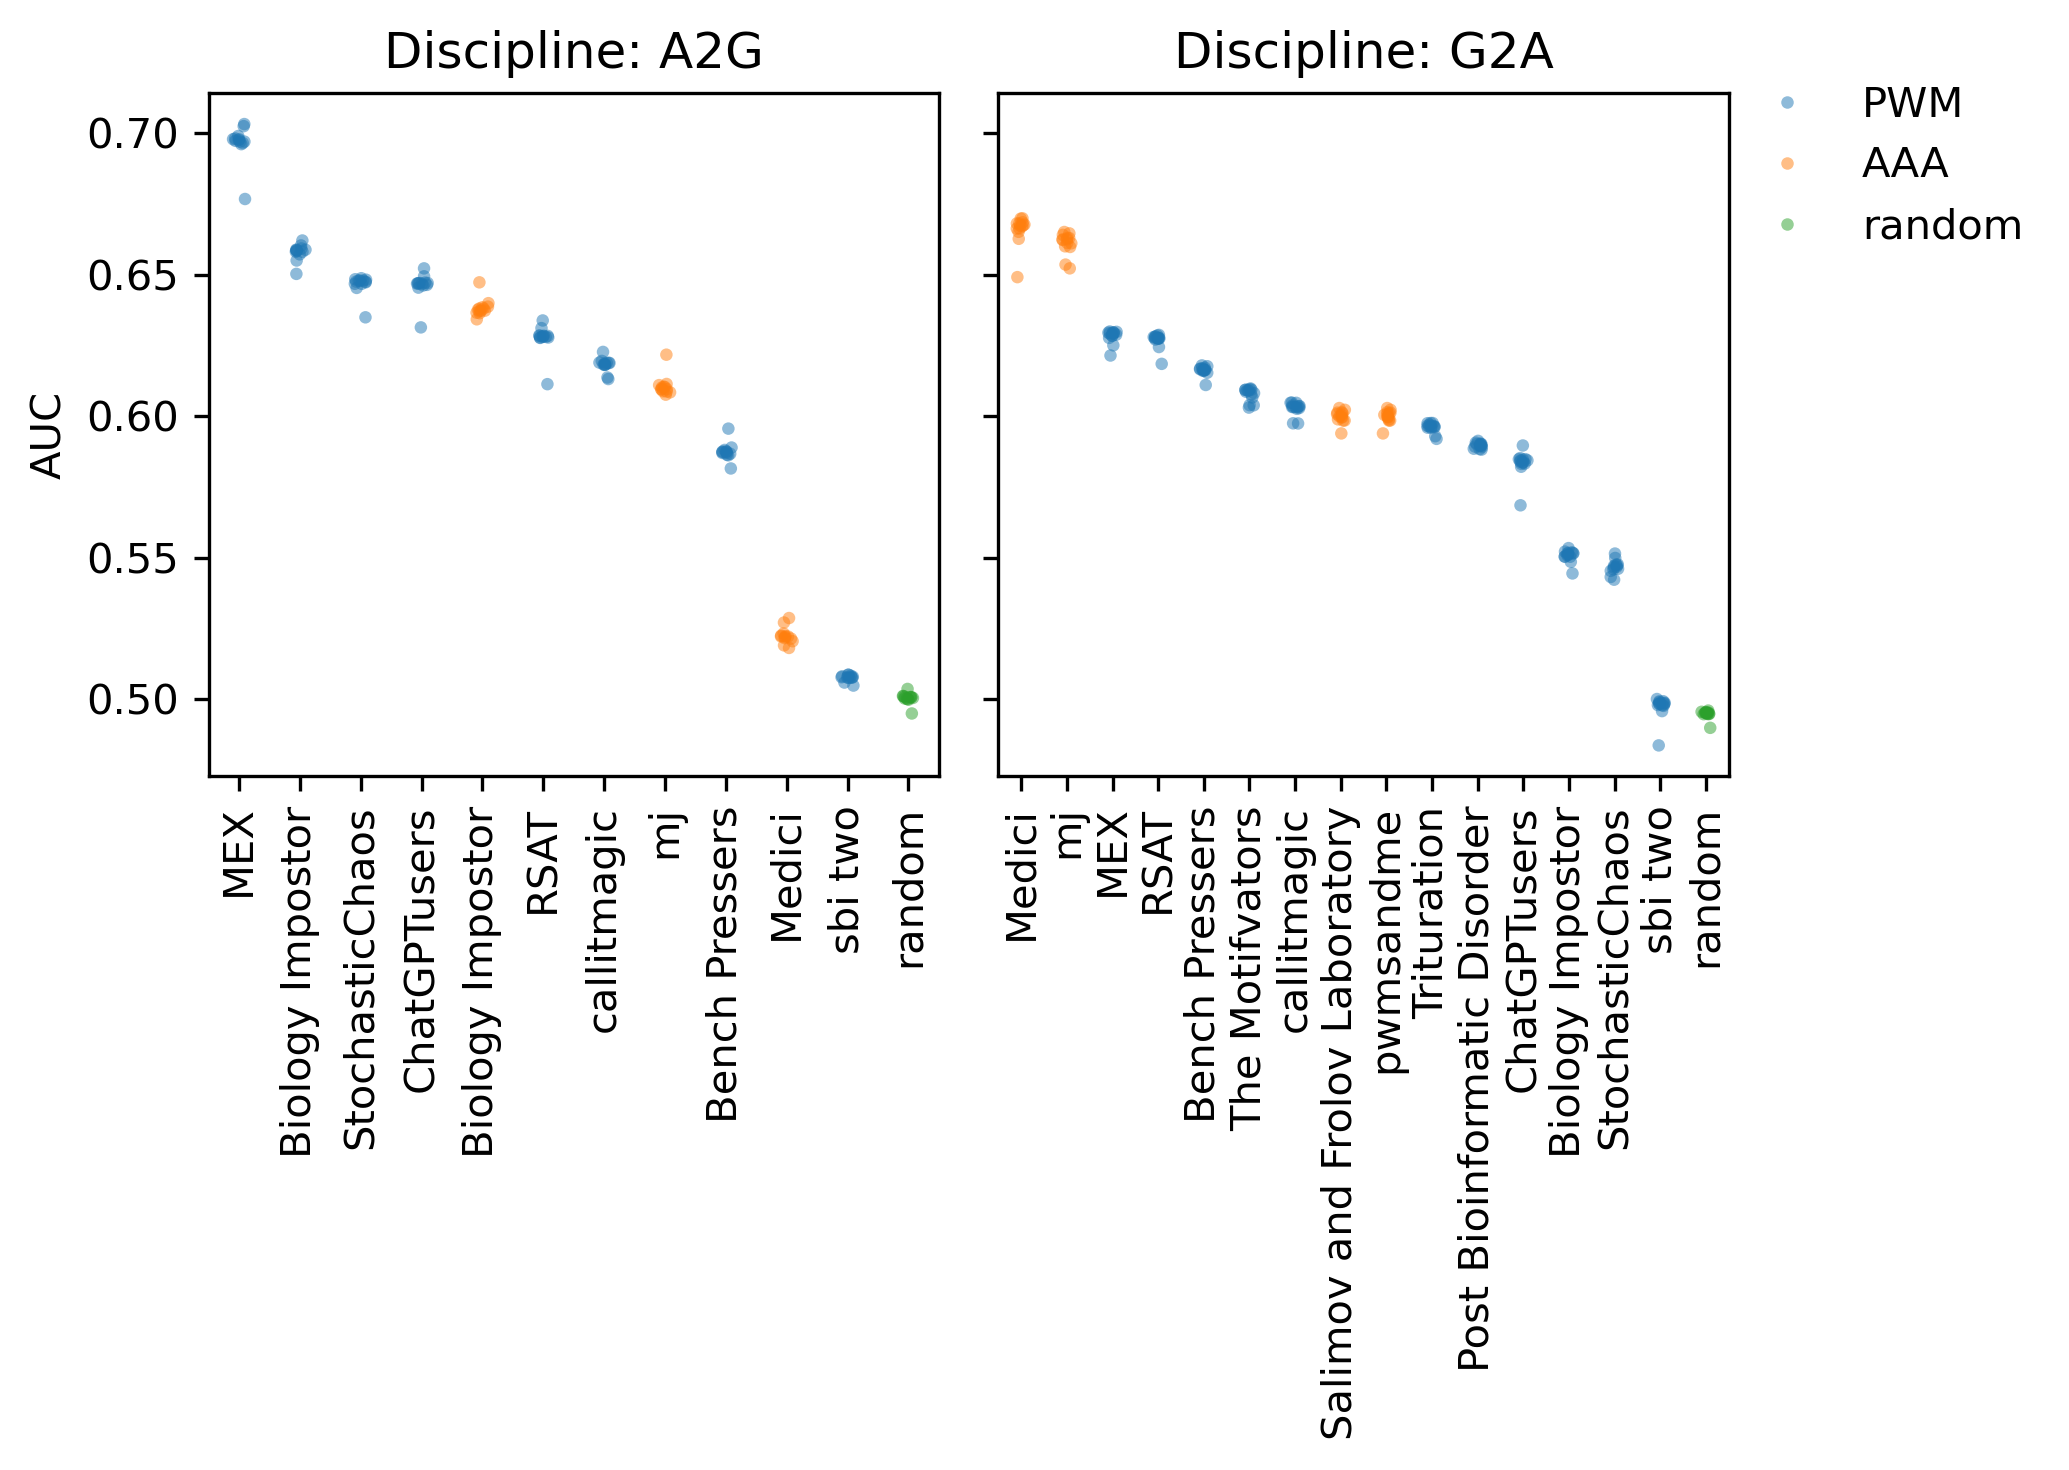

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), dpi=300, sharey=True)

maxs = weighted_auc.groupby(['team', 'discipline', 'model_type', 'tf'])[['auc']].max().reset_index()
medians = maxs.groupby(['team', 'discipline', 'model_type'])['auc'].median().reset_index()

for i, (ax, dis) in enumerate(zip(axs, maxs['discipline'].unique())):
    query = f'discipline == "{dis}"'
    mini_df = maxs.query(query)
    order = medians.query(query).sort_values('auc', ascending=False)['team']
    sns.stripplot(data=mini_df, x='team', y='auc', ax=ax, order=order, hue='model_type', size=3, alpha=0.5)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(order.str.replace('.', ' '), rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('AUC')
    ax.set_title(dis.replace('.', ': '))
    if i == 1:
        ax.legend(frameon=False, loc=[1, 0.75])
    else:
        ax.get_legend().remove()
fig.tight_layout()
plt.savefig('figures/aaa_auc_weighed_mean_strip.png', bbox_inches='tight')